# Convolutional Neural Network
### Importing the libraries

In [32]:
import os
import pandas as pd
import numpy as np

import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.14.0'

## Part 0 - Prepare the dataset
In this section, we will reorganize our dataset. 

Thus, we will move the images contained directly in the test, train, and valid folders into subfolders (hostile, passive) based on the nature of the creatures present in the respective image. 

The nature of each creature present in the image can be obtained from the _annotations.csv files present in each folder of the dataset

In [3]:
def sort_images_dataset(path_folder):
    """
    Sorts images in a dataset based on their class, moving them to separate folders.
    If the image represents a passive creature, it will be moved to the 'passive' subfolder, otherwise, it will be moved to the 'hostile' subfolder.

    Parameters:
        - path_folder (str): Path to the folder containing the images and _annotations.csv file.

    """
    PASSIVE_CLASS_LIST = ['chicken', 'cow', 'pig', 'sheep', 'bee', 'fox', 'frog', 'goat', 'llama', 'turtle', 'wolf']
    annotations_path = os.path.join(path_folder, '_annotations.csv')
    annotations_data = pd.read_csv(annotations_path)
    
    for filename, classe in annotations_data[['filename', 'class']].values:

        img_path = os.path.join(path_folder, filename)
        if os.path.exists(img_path):

            category = "passive" if classe in PASSIVE_CLASS_LIST else "hostile"
            category_dir = os.path.join(path_folder, category)

            if not os.path.exists(category_dir):
                os.makedirs(category_dir)
            
            new_img_path = os.path.join(category_dir, filename)
            os.rename(img_path, new_img_path)
    


In [4]:
path_dataset_to_sort = ['./data/train', './data/test', './data/valid']
for path in path_dataset_to_sort:
    sort_images_dataset(path)

## Part 1 - Data Preprocessing

> How are we going to preprocess our images? 

Actually, we are going to do multiple things. We will apply various transformations to all images in the training set. However, we will not apply the same transformations to the test set. The reason is to prevent overfitting. If we fail to apply these transformations properly during training on the training set, we will observe a significant difference in accuracy between the training and test sets. The accuracy on the training set will be very high, whereas it will be much lower on the test set.

In the realm of computer vision, the key to avoiding overfitting is to apply certain transformations.

> What do these transformations consist in ? 

They encompass simple geometrical transformations, zooms, rotations on our images, and more. This process is called image augmentation. The aim is to prevent the CNN from overlearning on the existing images. By applying these transformations, we generate new images, thereby increasing the variety and diversity of our dataset.



### Preprocessing the training set

## 

In [5]:
train_datagen = ImageDataGenerator(
                    rescale=1./255, # Normalisation / Feature scaling
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True
                )

In [6]:
training_set = train_datagen.flow_from_directory(
                        './data/train',
                        target_size=(128, 128), # final size of images
                        batch_size=32,
                        class_mode='binary'
                    )

Found 2307 images belonging to 2 classes.


### Preprocessing the test set and validation set

In [7]:
test_valid_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
valid_set = test_valid_datagen.flow_from_directory(
                './data/valid',
                target_size=(128, 128),
                batch_size=32,
                class_mode='binary'
            )

Found 422 images belonging to 2 classes.


In [9]:
test_set = test_valid_datagen.flow_from_directory(
                './data/test',
                target_size=(128, 128),
                batch_size=32,
                class_mode='binary',
                shuffle=False
            )

Found 155 images belonging to 2 classes.


## Part 2 - Building the CNN

Here, you have two options:
- Load the previously saved CNN model.
- Instantiate a new model, which you will need to train.

If you already have the model trained, you can simply run the next cell. There's no need to initialize the CNN and train it again.


In [33]:
cnn = load_model("model.h5")

### Initialising the CNN

In [10]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

The input to a convolutional layer is typically an image. The convolutional layer applies filters, also known as kernels/feature detector, to this input. Each filter is a small matrix that is slid across the input image. 

The filter is moved across the input using a defined step size (stride), and at each position, an element-wise multiplication of the filter values and the corresponding input values is performed. The resulting values are summed to produce a single value for that position, forming a new output known as a feature map.

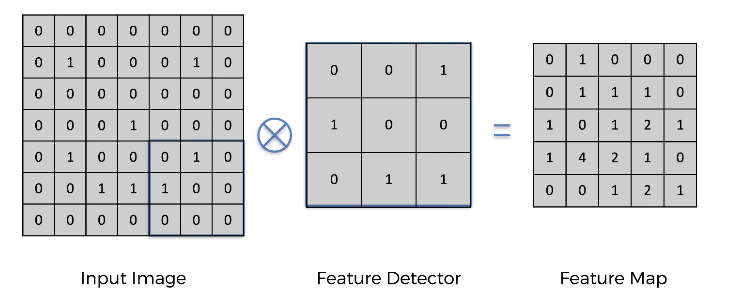

The feature map highlights specific patterns or features present in the input data, such as edges, textures, or shapes.

After the convolution operation, a non-linear activation function (e.g., ReLU - Rectified Linear Unit) is often applied to introduce non-linearity into the model.

In [11]:
conv_layer = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=[128,128,3])
cnn.add(conv_layer)

The previous code defines a 2D convolutional layer which consist in 32 filters (filters), each scanning a 3x3 region (kernel_size). The 'relu' activation function adds non-linearity. The layer expects 128x128 input images with three color channels. 

### Step 2 - Pooling

We shouldn't forget the Pooling step. This is a crucial technique in CNN in order to reduce the spatial dimensions of feature maps while retaining essential information. 

One common pooling technique is max pooling, which operates by dividing the input into small regions (pool_size), often 2x2 or 3x3, and retaining the maximum value from each region. 

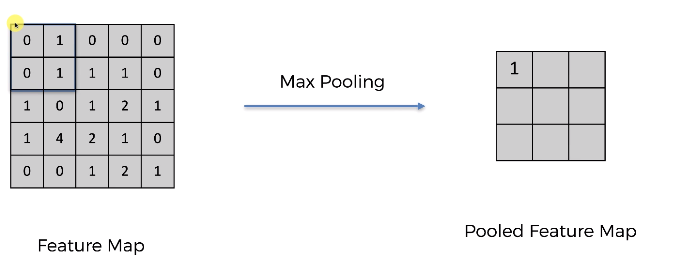

Subsequently, the small region shifts to the right with a step of 2.

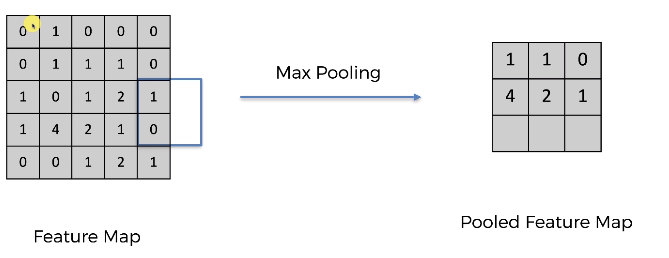

This process effectively downscales the feature map, reducing computational complexity and preventing overfitting by focusing on the most significant features. 

In [12]:
pooling_layer = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
cnn.add(pooling_layer)

### Adding a second convolution layer

We often use multiple layers that apply different filters to the input. Each layer learns to recognize specific patterns or features, becoming more complex as we go deeper.

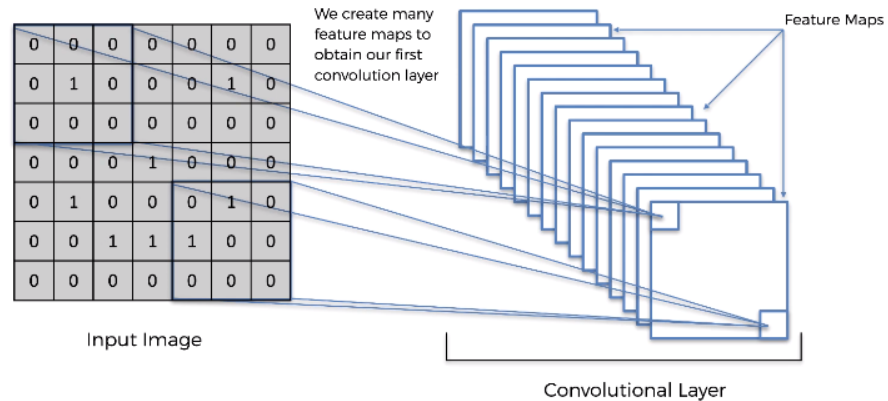

In [13]:
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Step 3 - Flattening

Flattening is about converting a multi-dimensional array into a one-dimensional array. It's like taking a 2D grid and transforming it into a straight line, where all the elements are listed sequentially. 

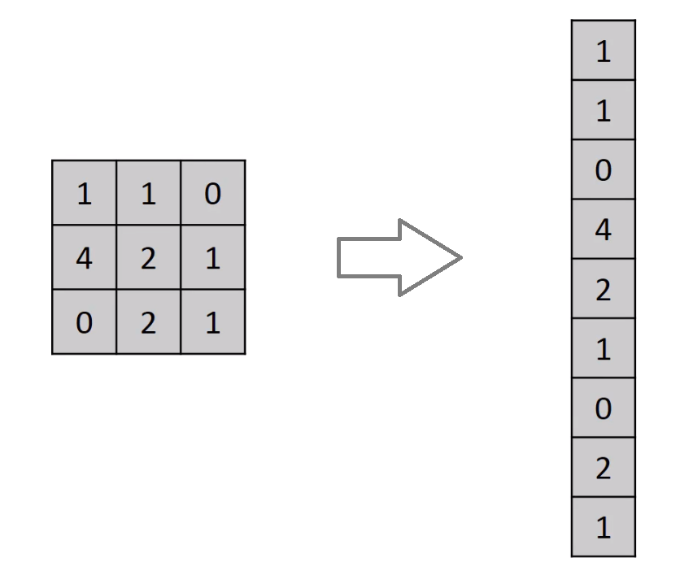

It's often used as a precursor to passing the data through a fully connected layer for further processing or classification

In [14]:
flattening_layer = tf.keras.layers.Flatten()
cnn.add(flattening_layer)

### Step 4 - Full Connection

In [15]:
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))

### Step 5 - Output Layer

In [16]:
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## Part 3 - Training the CNN
### Compiling the CNN

When we compile a CNN, we are connecting it to crucial features that define how it learns and evaluates its performance. 

The compilation involves specifying :
- **An optimizer**, which dictates how the network updates its weights to minimize the loss. 
- **A loss function** that quantifies the difference between the predicted outputs and the true targets. This guides the network to improve its predictions during training. 
- **Specific metrics** that help us evaluate the CNN's performance, such as accuracy.

In [17]:
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

### Training the CNN on the training set and evaluating it on the validation set

In [18]:
cnn.fit(x = training_set, validation_data = valid_set, epochs = 35)

Epoch 1/35
73/73 [==============================] - 35s 470ms/step - loss: 0.6257 - accuracy: 0.7130 - val_loss: 0.7903 - val_accuracy: 0.4905
Epoch 2/35
73/73 [==============================] - 33s 453ms/step - loss: 0.4624 - accuracy: 0.7789 - val_loss: 1.3057 - val_accuracy: 0.4621
Epoch 3/35
73/73 [==============================] - 33s 453ms/step - loss: 0.3815 - accuracy: 0.8366 - val_loss: 1.0171 - val_accuracy: 0.4787
Epoch 4/35
73/73 [==============================] - 33s 453ms/step - loss: 0.3583 - accuracy: 0.8500 - val_loss: 1.0429 - val_accuracy: 0.4526
Epoch 5/35
73/73 [==============================] - 33s 455ms/step - loss: 0.3007 - accuracy: 0.8808 - val_loss: 1.2710 - val_accuracy: 0.4621
Epoch 6/35
73/73 [==============================] - 33s 451ms/step - loss: 0.2751 - accuracy: 0.8825 - val_loss: 1.6032 - val_accuracy: 0.4313
Epoch 7/35
73/73 [==============================] - 33s 453ms/step - loss: 0.2636 - accuracy: 0.8964 - val_loss: 1.2379 - val_accuracy: 0.4526

The fitting process demonstrates convergence at approximately the 32nd epoch.

We can now same the model

In [30]:
cnn.save('model.h5')

c:\Users\charp\Desktop\Minecraft-Mob-Detection\.venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Part 4 - Making a single prediction

Now, we're about to perform a single prediction. Initially, we load the image as a PIL image. However, since the predict method expects a 2D array, we need to transform it accordingly. It's essential to consider the model's training procedure, which was done in batches, necessitating the addition of a new dimension to align with the expected input shape.

Here, I've provided the path to an image from the test set, specifically representing a passive mob. However, feel free to use any image you prefer; it doesn't necessarily have to come from this dataset.

In [19]:
path_img_test = './data/test/passive/-45-_jpg.rf.cdf668b9120a042e73f237e274337169.jpg'
test_image = image.load_img(path_img_test, target_size = (128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

Now we can do the prediction

In [20]:
result = cnn.predict(test_image/255.0)
print(result)

1/1 [==============================] - 0s 82ms/step
[[1.]]


But what do '0' and '1' signify? Do they represent a hostile mob or a passive mob in my picture? To ascertain this, we'll utilize the following line of code, which will help us determine the prediction and provide clarity on the model's classification for the given image.

In [21]:
print(training_set.class_indices)

{'hostile': 0, 'passive': 1}


Here, we equate a hostile mob to '0' and a passive mob to '1'.

However, it's important to note that the actual prediction result may not always be a strict '0' or '1' due to the confidence score associated with the prediction.

In [22]:
prediction_img = result[0][0]

if prediction_img < 0.5: 
  print('This is an hostile mob.')
else:
  print('This is a passive mob.')

This is a passive mob.


The result is true because the image was extracted from a passive subfolder, one that was not utilized for training and testing the model.

## Part 5 - Model Performance Evaluation using the test set
I conduct predictions on the test set to assess the model's performance.

In [23]:
prediction = cnn.predict(test_set)

5/5 [==============================] - 1s 96ms/step


In [24]:
y_pred = prediction.flatten()
y_pred = np.where(y_pred < 0.5, 0, 1)

In [25]:
y_true = test_set.classes

In [26]:
y_pred

array([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [27]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

Calculate and display the confusion matrix

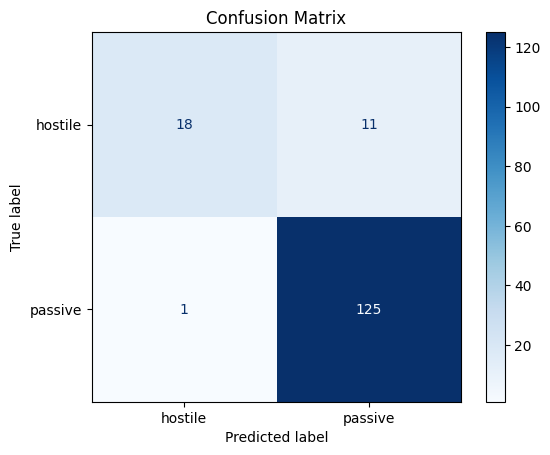

In [28]:
conf_matrix = confusion_matrix(y_true, y_pred)

class_names = ['hostile', 'passive']
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='.4g')
plt.title('Confusion Matrix')
plt.show()

Classification report

In [29]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     hostile       0.95      0.62      0.75        29
     passive       0.92      0.99      0.95       126

    accuracy                           0.92       155
   macro avg       0.93      0.81      0.85       155
weighted avg       0.92      0.92      0.92       155

